# Wildfire Detection Threshold Model

author : camen  
last run : Apr 24, 2020

In [1]:
from collections import namedtuple
import datetime

import matplotlib.pyplot as plt
import numpy as np

from wildfire.data import goes_level_1

LOCAL_DIRECTORY = "./temporary_output"

## Introduction

Xu Zhong, an IBM researcher, set up a threshold model to detect wildfires in Australia using the Himawari-8 satellite. It is discussed [in this paper](https://www.researchgate.net/publication/318455389_Real-time_wildfire_detection_and_tracking_in_Australia_using_geostationary_satellite_Himawari-8) and this notebook provides an implementation of their model using GOES-R satellite data to detect wildfires in the United States.

The algorithm is:

- is_hot()? -> false -> end
- is_hot()? -> true -> is_night()? -> true -> end
- is_hot()? -> true -> is_night()? -> false -> is_not_cloud()? and is_not_water? -> end

## Data

In [2]:
goes_scan_1 = goes_level_1.get_goes_scan(
    satellite="noaa-goes17", 
    region="M1", 
    scan_time_utc=datetime.datetime(2019, 10, 27, 20, 0), 
    local_directory=LOCAL_DIRECTORY
)
goes_scan_2 = goes_level_1.get_goes_scan(
    satellite="noaa-goes17", 
    region="M1", 
    scan_time_utc=datetime.datetime(2019, 10, 10, 20, 0), 
    local_directory=LOCAL_DIRECTORY
)
goes_scan_3 = goes_level_1.get_goes_scan(
    satellite="noaa-goes17", 
    region="M1", 
    scan_time_utc=datetime.datetime(2019, 11, 1, 18, 0), 
    local_directory=LOCAL_DIRECTORY
)

scanning_group = (goes_scan_1, goes_scan_2, goes_scan_3)

## Find Hot Pixels

In [3]:
def is_hot(band_7, band_14):
    return (
        (goes_level_1.band.normalize(band_7.brightness_temperature.data) > 2) & 
        (goes_level_1.band.normalize(band_7.brightness_temperature.data - band_14.brightness_temperature.data) > 3)
    )

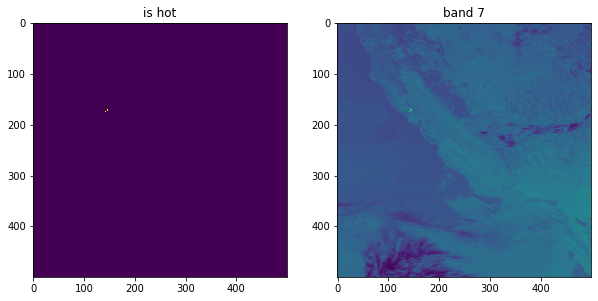

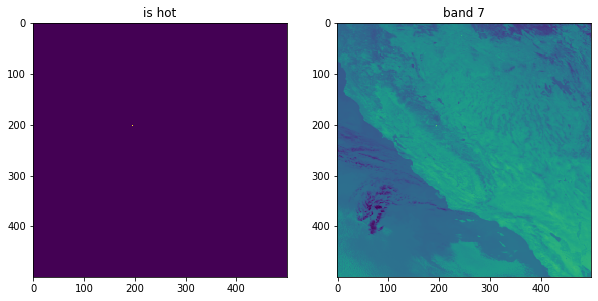

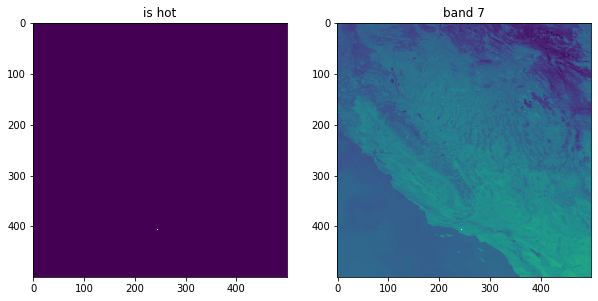

In [4]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    
    axes[0].imshow(is_hot(scan["band_7"], scan["band_14"]))
    axes[0].set_title("is hot")
    
    axes[1].imshow(scan["band_7"].brightness_temperature)
    axes[1].set_title("band 7")

## Filter Clouds

In [5]:
def is_cloud(band_2, band_3, band_15):
    band_2 = band_2.reflectance_factor[::4, ::4].data
    band_3 = band_3.reflectance_factor[::2, ::2].data
    band_15 = band_15.brightness_temperature.data
    condition_1 = (band_2 + band_3) >= 1.2
    condition_2 = band_15 <= 265
    condition_3 = ((band_2 + band_3) >= 0.5) & (band_15 <= 285)
    return condition_1 | condition_2 | condition_3

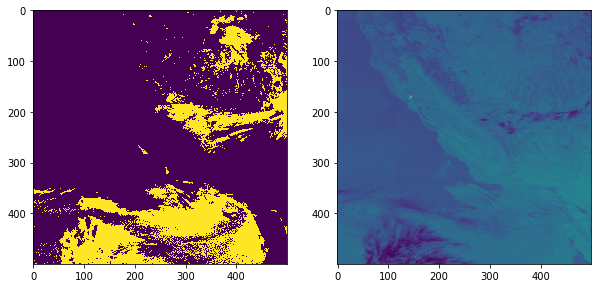

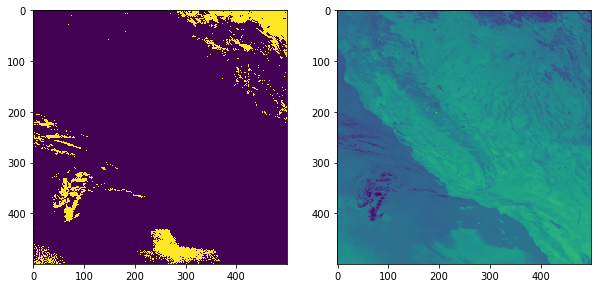

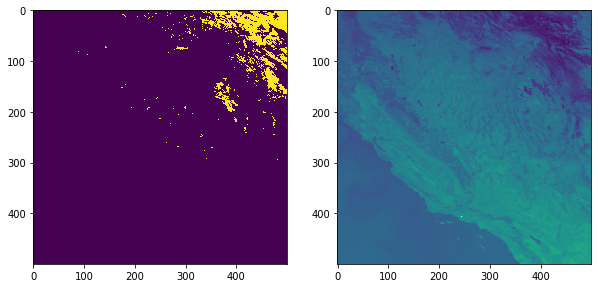

In [6]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(is_cloud(scan["band_2"], scan["band_3"], scan["band_15"]))
    axes[1].imshow(scan["band_7"].brightness_temperature)
    plt.show()
    plt.close();

## Filter Water Pixels

In [7]:
def is_water(band_6):
    return band_6.reflectance_factor.data <= 0.03

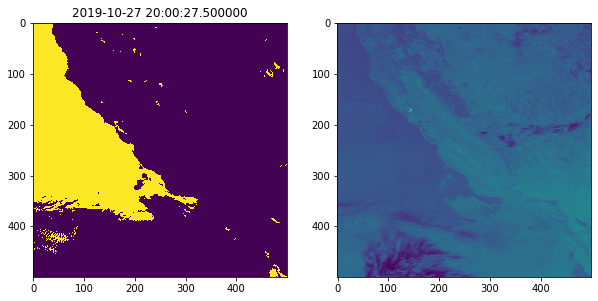

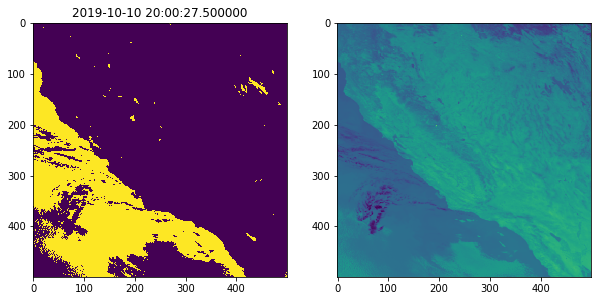

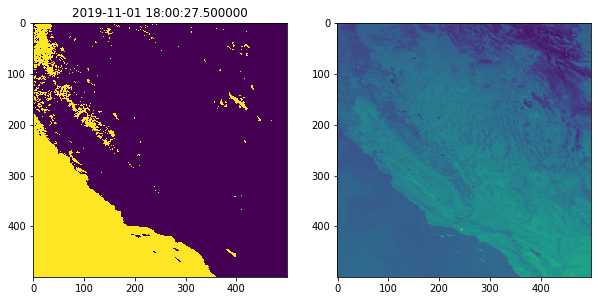

In [8]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(is_water(scan["band_6"]))
    axes[1].imshow(scan["band_7"].brightness_temperature)
    axes[0].set_title(scan["band_2"].scan_time_utc)

## Is Night?

There are few false positives at night, so if it is night we can skip filtering out water and cloud pixels

In [9]:
goes_scan_1_night = goes_level_1.get_goes_scan(
    satellite="noaa-goes17", 
    region="M1", 
    scan_time_utc=datetime.datetime(2019, 10, 27, 10, 0),
    local_directory=LOCAL_DIRECTORY
)
goes_scan_2_night = goes_level_1.get_goes_scan(
    satellite="noaa-goes17", 
    region="M1", 
    scan_time_utc=datetime.datetime(2019, 10, 10, 10, 0),
    local_directory=LOCAL_DIRECTORY
)
goes_scan_3_night = goes_level_1.get_goes_scan(
    satellite="noaa-goes17", 
    region="M1", 
    scan_time_utc=datetime.datetime(2019, 11, 1, 8, 0),
    local_directory=LOCAL_DIRECTORY
)

scanning_group_night = (goes_scan_1_night, goes_scan_2_night, goes_scan_3_night)

In [10]:
def is_night(band_2, band_3):
    return (
        (np.abs(band_2.reflectance_factor.data[::4, ::4]) < 0.008) | 
        (np.abs(band_3.reflectance_factor.data[::2, ::2]) < 0.008)
    )

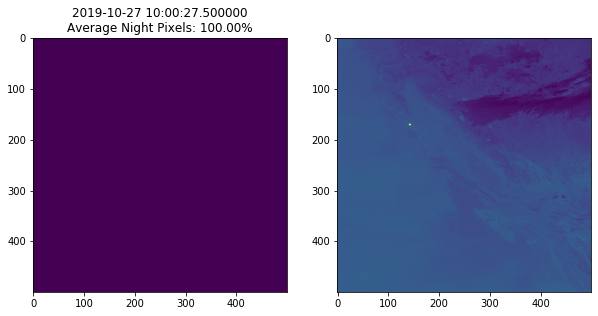

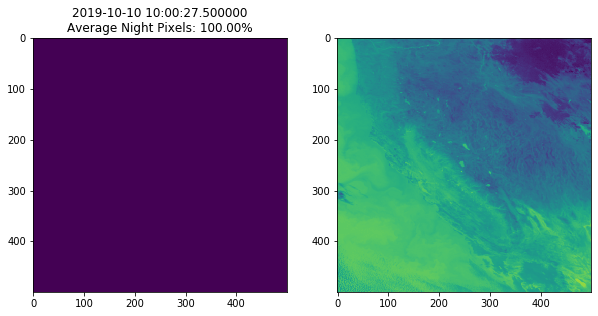

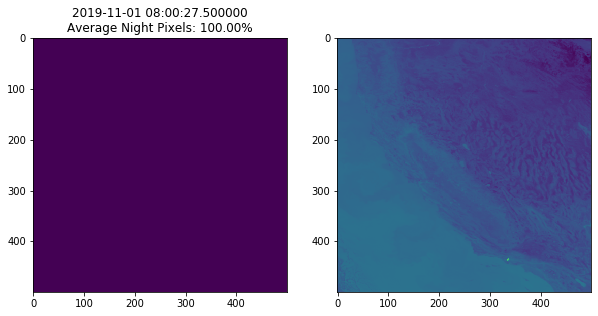

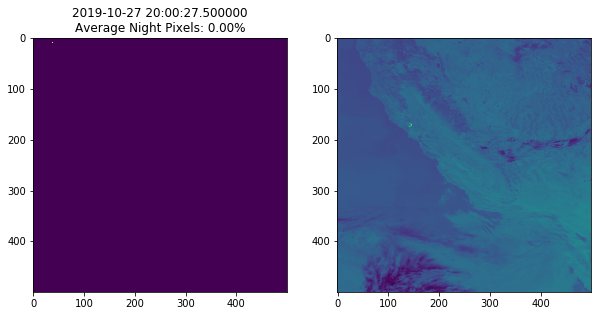

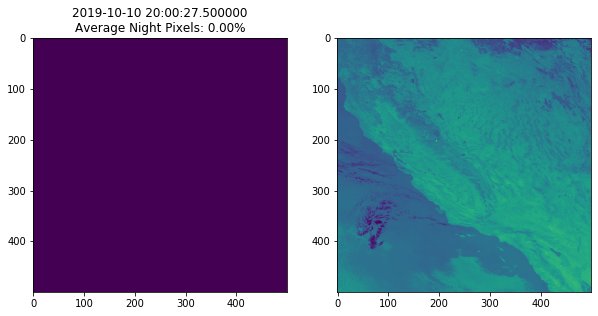

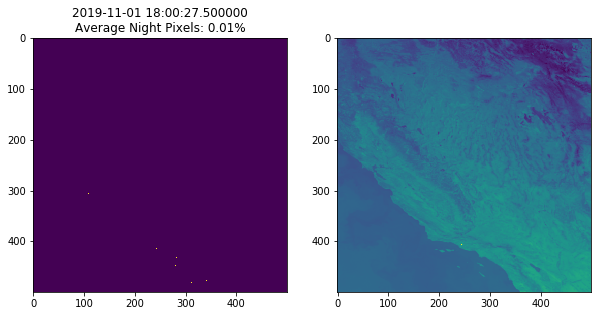

In [11]:
for scan in scanning_group_night + scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    night = is_night(scan["band_2"], scan["band_3"])
    axes[0].set_title(f"{scan['band_2'].scan_time_utc}\nAverage Night Pixels: {night.mean() * 100:.2f}%")
    axes[0].imshow(night)
    axes[1].imshow(scan["band_7"].brightness_temperature);

## Is Fire?

In [12]:
def is_fire(scan):
    return (
        is_hot(scan["band_7"], scan["band_14"]) & 
        (
            is_night(scan["band_2"], scan["band_3"]) |
            (
                ~is_cloud(scan["band_2"], scan["band_3"], scan["band_15"]) &
                ~is_water(scan["band_6"])
            )
        )
    )

def plot_wildfire(scan):
    fire = is_fire(scan)
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(fire)
    axes[1].imshow(scan["band_7"].brightness_temperature)
    plt.title(f"{scan['band_7'].scan_time_utc}\n{fire.mean() > 0}")
    plt.show()
    plt.close();

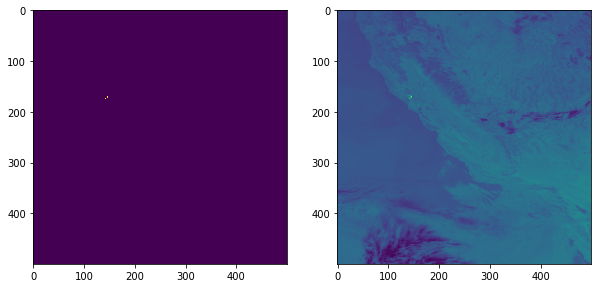

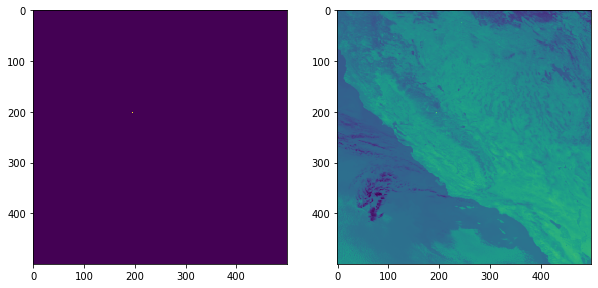

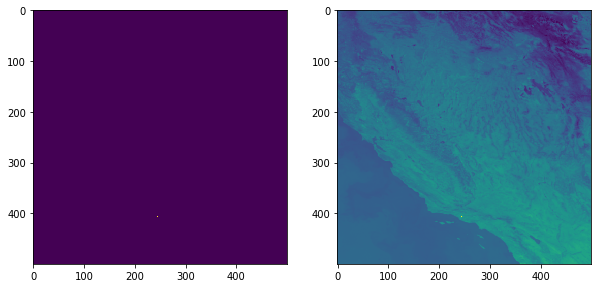

In [13]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(is_fire(scan))
    axes[1].imshow(scan["band_7"].brightness_temperature)
    plt.show()
    plt.close();